<h1><center>Cruise Reviews - EDA</center></h1>

In [1]:
!jt -r

Reset css and font defaults in:
/Users/hernan/.jupyter/custom &
/Users/hernan/Library/Jupyter/nbextensions


![title](canada-cruise-homepage.jpg)

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import re
import string
warnings.filterwarnings('ignore')


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Add settings for SNS

In [3]:
reviews = pd.read_csv('reviews.csv', index_col=0)
reviews.columns = ['ship_link', 'links', 'user_date',
       'user_link', 'user_contributions',
       'user_helpful_votes', 'stars', 'title',
       'content', 'meta', 'user_hometown']

In [4]:
def save_pickle(element,file):
    with open(file, 'wb') as handle:
        pickle.dump(element, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

# Data cleaning

In [5]:
#Checking the number of observations and columns
reviews.shape

(9607, 11)

In [6]:
#Checking how data looks like
reviews.head(3)

,ship_link,links,user_date,user_link,user_contributions,user_helpful_votes,stars,title,content,meta,user_hometown
0,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743487186-MSC_M...,Tony K|Yesterday,/Profile/L9746OCtonyk,62,5,40,MSC Meraviglia Yacht Club,We sailed on the MSC Meraviglia for the first ...,Sail Date: January 2020|Cabin Type: Balcony|Ty...,"Seattle, Washington"
1,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743427041-MSC_M...,ann b|Yesterday,/Profile/bhayden,10,11,10,never again,This ship is a huge nightmare. I am in decent...,Sail Date: February 2020|Cabin Type: Balcony|T...,orchard park NY
2,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743305803-MSC_M...,Lsabina11|5 Feb,/Profile/Lsabina11,289,57,50,Awesome experience at great value,Four of us just came back from a MSC Meravigli...,Sail Date: February 2020|Cabin Type: Balcony|T...,"Innisfil, Canada"


In [7]:
# Information about data types and non-null values
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9607 entries, 0 to 9606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ship_link           9607 non-null   object
 1   links               9607 non-null   object
 2   user_date           9607 non-null   object
 3   user_link           9607 non-null   object
 4   user_contributions  9607 non-null   object
 5   user_helpful_votes  9607 non-null   object
 6   stars               9607 non-null   int64 
 7   title               9607 non-null   object
 8   content             9607 non-null   object
 9   meta                9596 non-null   object
 10  user_hometown       7661 non-null   object
dtypes: int64(1), object(10)
memory usage: 900.7+ KB


**Observation:** User contributions and helpful votes should be integers, however since the original numbers on the website included commas, this were considered as strings by pandas. The following should fix it.

In [8]:
# Cleaning fields and casting them as integer columns.

reviews.user_contributions = reviews.user_contributions.str.replace(',','').astype(int)
reviews.user_helpful_votes = reviews.user_helpful_votes.str.replace(',','').astype(int)

**Observation:** User Name and Date are in the same column.

In [9]:
#Extracting User Name
reviews['user'] = reviews.user_date.apply(lambda x: x.split('|')[0].strip())
#Extracting Date
reviews['date'] = reviews.user_date.apply(lambda x: x.split('|')[1].strip())
reviews['date'] = reviews['date'].apply(lambda x: x if x[-4:-2] == '20' else 'Feb 2020')
# Extracting year from date
reviews['year'] = reviews['date'].apply(lambda x: x.split(' ')[1])
reviews['month'] = reviews['date'].apply(lambda x: x.split(' ')[0])

**Observation:** Meta column contains multiple features.

In [10]:
reviews.head(3).meta.values

array(['Sail Date: January 2020|Cabin Type: Balcony|Type of Trip: |Destination: Caribbean|',
       'Sail Date: February 2020|Cabin Type: Balcony|Type of Trip: |Destination: Caribbean|',
       'Sail Date: February 2020|Cabin Type: Balcony|Type of Trip: Family (older kids)|Destination: Caribbean|'],
      dtype=object)

In [11]:
reviews.drop(reviews[reviews.meta.isnull()].index,inplace = True)

In [12]:
#Extracting columns data from meta data
reviews['sail_date'] = reviews['meta'].apply(lambda x: x.split('|')[0].replace('Sail Date: ',''))
reviews['cabin_type'] = reviews['meta'].apply(lambda x: x.split('|')[1].replace('Cabin Type: ',''))
reviews['trip_type'] = reviews['meta'].apply(lambda x: x.split('|')[2].replace('Type of Trip: ',''))
reviews['destination'] = reviews['meta'].apply(lambda x: x.split('|')[3].replace('Destination: ',''))
reviews.replace({'':np.NaN},inplace = True)

In [13]:
def extract_country(hometown):
    try:
        return hometown.split(',')[1].strip()
    except:
        return hometown

reviews['user_country'] = reviews.user_hometown.apply(extract_country)

**Observation:** Stars are are represented as multiples of 10: 1 star = 10 and 5 stars = 50. I will remove the last zero. 

In [14]:
reviews['stars'] = (reviews['stars']/10).astype(int)

**Getting word count**

In [15]:
reviews['word_count'] = reviews.content.apply(
    lambda x: len(re.sub('\s\s+',' ',re.sub('([^\w\s])','',x)).split(' ')))

## Clean Data

### Data available
After cleaning the data, only 2 fields contain nulls: User hometown and trip type. Whilst "user hometown" isn't a mandatory field when users fill reviews, the type of trip must be completed. However, due to recent changes on the website, whenever the user filled sub_ratings, these would show instead of the trip type. 

![title](review_missing.png)


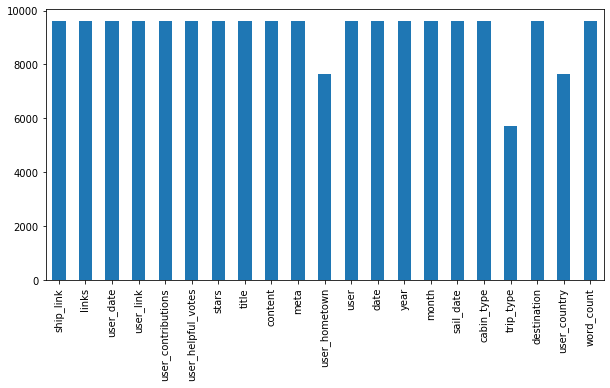

In [16]:
available_data = (len(reviews)-reviews.isna().sum())
fig, ax = plt.subplots(figsize = (10,5));
available_data.plot(kind = 'bar');

### Content word count

## Target Variable

5    0.431013
4    0.246978
3    0.151209
2    0.087328
1    0.083472
Name: stars, dtype: float64


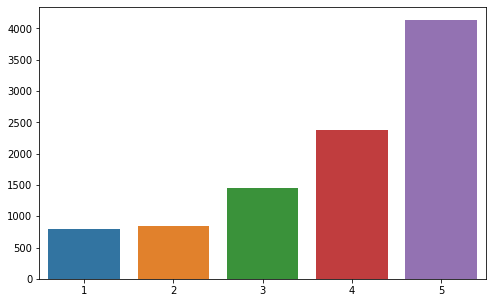

In [17]:
star_counts = reviews.stars.value_counts().sort_values(ascending = True)
#Printing %
print(reviews.stars.value_counts(normalize=True))
#Plotting %
plt.figure(figsize=(8,5));
sns.barplot(x = star_counts.index, y = star_counts.values,);

### Relabeling Stars

In [18]:
reviews['stars_grouped'] = reviews.stars.map({1:'Bad Review',
                                              2:'Bad Review',
                                              3:'Bad Review',
                                              4:'Good Review',
                                              5:'Good Review'})

Good Review    0.677991
Bad Review     0.322009
Name: stars_grouped, dtype: float64


[Text(0, 0, 'Bad Review'), Text(0, 0, 'Good Review')]

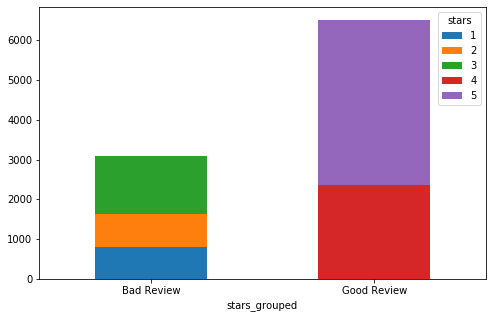

In [19]:
print(reviews.stars_grouped.value_counts(normalize=True))
fig, ax = plt.subplots(figsize=(8,5));
reviews.groupby(['stars_grouped','stars'])['stars'].count().unstack().plot.bar(stacked = True, ax = ax);
ax.set_xticklabels(ax
                   .get_xticklabels(), rotation=0)

### Available Data

**Review Specific**
- Stars: Rating given by user
- Title: Review Title
- Content: Review (text without title)
- Date: Review Date (MONTH AND YEAR)

**User Specific**
- User: User name
- User Contributions: Number of reviews, pictures uploaded, etc (not just other reviews).
- User Helpful votes: ????
- User Country: Obtained from user location. NEEDS CLEANING!!!! US STATES appear as countries, some broken data too. 

**Trip Additional info**
- Sail date: When did the user travelled.
- Cabin Type: Balcony, Outside, Inside, Suite
- Trip Type: Solo, Friends, Couple, Family (Younger Kids), Family (Older Kids), Family Multi-Generational -(Incomplete)
-Destionation: Destionation of cruise. Might need additional cleaning. 

**Other Information**
-Besides the main data displayed below, I also have:
    - User link --> Could be used to download all user reviews and connect with current data.
    - Ship Link --> Can be used to download additional cruise information (size of cruise, destinations, etc).


In [20]:
reviews[['stars_grouped','stars','title','content','date',
         'user','user_contributions','user_helpful_votes','user_country',
         'sail_date','cabin_type', 'trip_type', 'destination']].head(3)

,stars_grouped,stars,title,content,date,user,user_contributions,user_helpful_votes,user_country,sail_date,cabin_type,trip_type,destination
0,Good Review,4,MSC Meraviglia Yacht Club,We sailed on the MSC Meraviglia for the first ...,Feb 2020,Tony K,62,5,Washington,January 2020,Balcony,NaN,Caribbean
1,Bad Review,1,never again,This ship is a huge nightmare. I am in decent...,Feb 2020,ann b,10,11,orchard park NY,February 2020,Balcony,NaN,Caribbean
2,Good Review,5,Awesome experience at great value,Four of us just came back from a MSC Meravigli...,Feb 2020,Lsabina11,289,57,Canada,February 2020,Balcony,Family (older kids),Caribbean


**Note**: Although Trip Type is a mandatory field when submitting a review, it seems that when the subscores (which are optional) are displayed, the Trip Type stops being displayed. 

In [21]:
reviews.to_csv('reviews_step_1.csv')

# EDA

## Numerical variables (or sort of...)

In [22]:
###STEP 1
###LOAD ME
### HERE
reviews = pd.read_csv('reviews_step_1.csv', index_col=0)
reviews.shape

(9596, 22)

### Pairplots

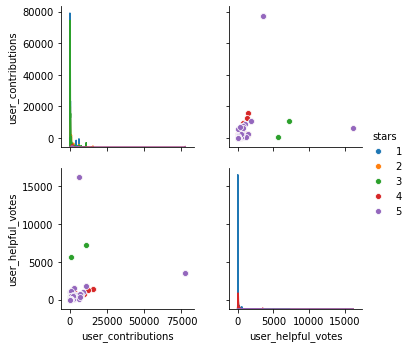

In [23]:
sns.pairplot(reviews,vars = ['user_contributions','user_helpful_votes'], hue = 'stars');

### Histograms (Y Log-scaled)

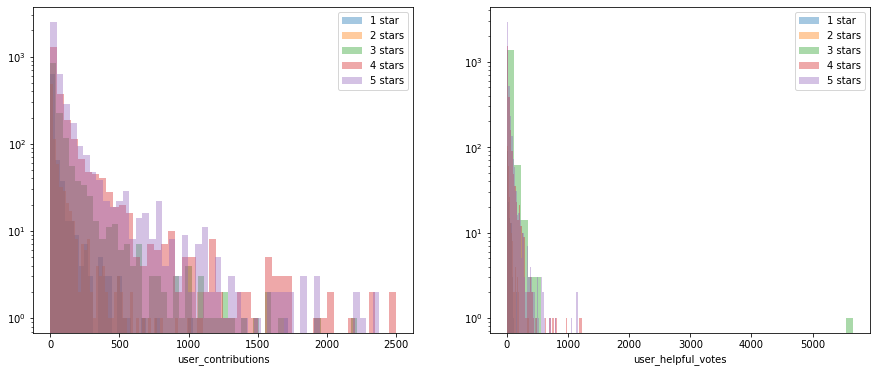

In [65]:
cont_outliers = (reviews['user_contributions']>2500)
help_outliers = (reviews['user_contributions']>2000)
fig, ax = plt.subplots(figsize = (15,6), ncols = 2)
for x in [1,2,3,4,5]:
    sns.distplot(reviews[(reviews.stars == x)&~cont_outliers]['user_contributions'],
                 ax = ax[0],hist = True, kde = False)
    ax[0].set_yscale('log')
    ax[0].legend(['1 star','2 stars','3 stars','4 stars','5 stars'])
for x in [1,2,3,4,5]:
    sns.distplot(reviews[(reviews.stars == x)&~help_outliers]['user_helpful_votes'],
                 ax = ax[1],hist = True, kde = False)
    ax[1].set_yscale('log')
    ax[1].legend(['1 star','2 stars','3 stars','4 stars','5 stars'])


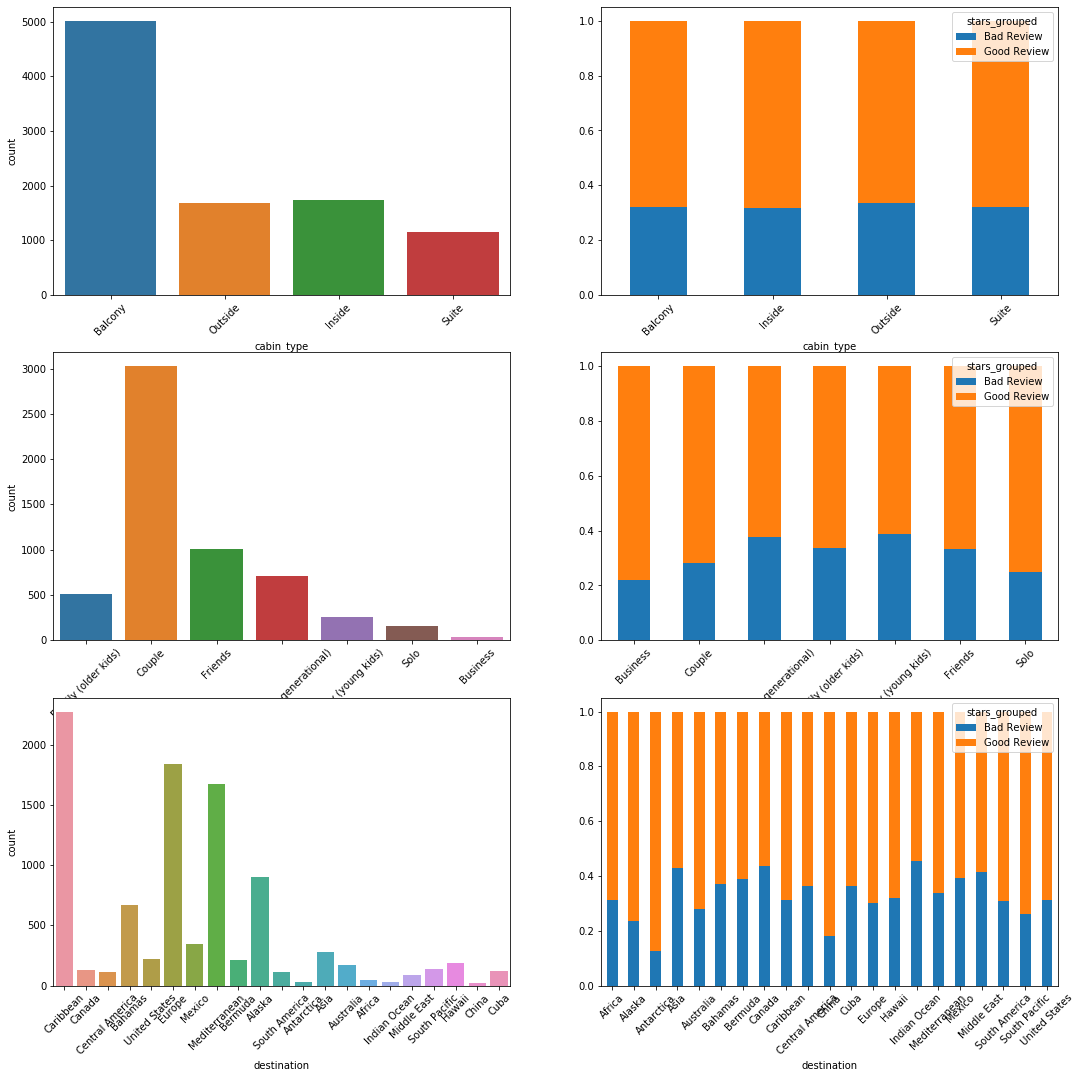

In [35]:
columns = ['cabin_type', 'trip_type', 'destination']

fig, ax = plt.subplots(nrows =len(columns), ncols = 2, figsize = (18,len(columns)*6))

for coln in range(len(columns)):
        sns.countplot(x = columns[coln], data = reviews, ax = ax[coln,0])
        ax[coln,0].set_xticklabels(ax[coln,0].get_xticklabels(), rotation=45)
        A = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack() 
        B = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack().sum()
        (A/B).T.plot(kind = 'bar', stacked = True,ax = ax[coln,1])
        ax[coln,1].set_xticklabels(ax[coln,1].get_xticklabels(), rotation=45)


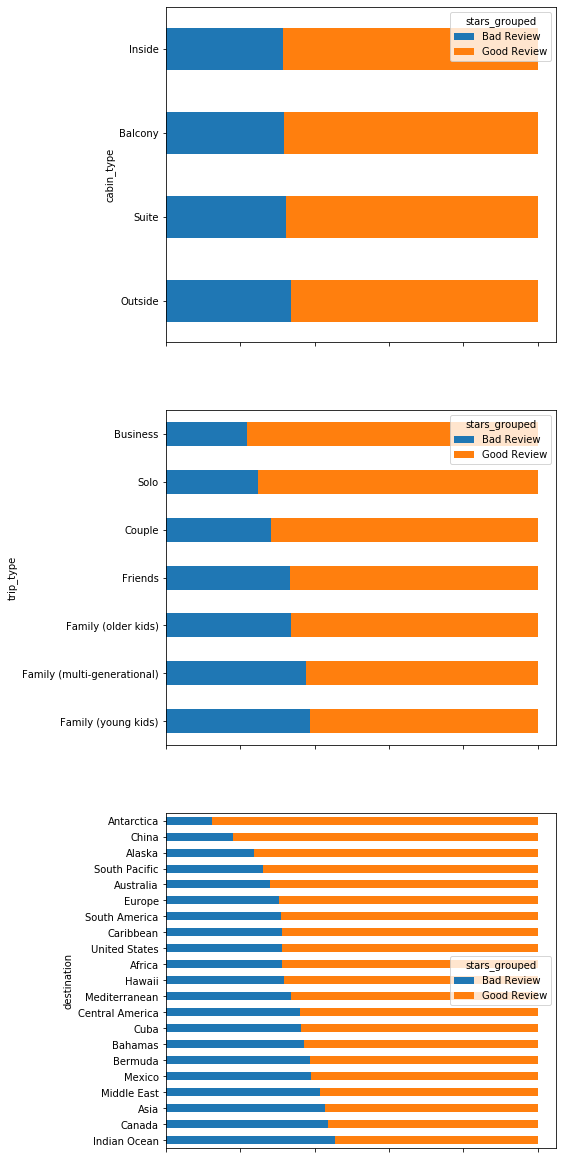

In [42]:
columns = ['cabin_type', 'trip_type', 'destination']

fig, ax = plt.subplots(nrows =len(columns), ncols = 1, figsize = (7,len(columns)*7))

for coln in range(len(columns)):
#         sns.countplot(x = columns[coln], data = reviews, ax = ax[coln,0])
#         ax[coln,0].set_xticklabels(ax[coln,0].get_xticklabels(), rotation=45)
        A = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack() 
        B = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack().sum()
        (A/B).T.sort_values(by = 'Bad Review', ascending = False).plot(kind = 'barh', stacked = True,ax = ax[coln])
        ax[coln].set_xticklabels(ax[coln].get_xticklabels(), rotation=45)

## Word Count

Text(0.5, 1.0, 'Word Count by Good/Bad Reviews')

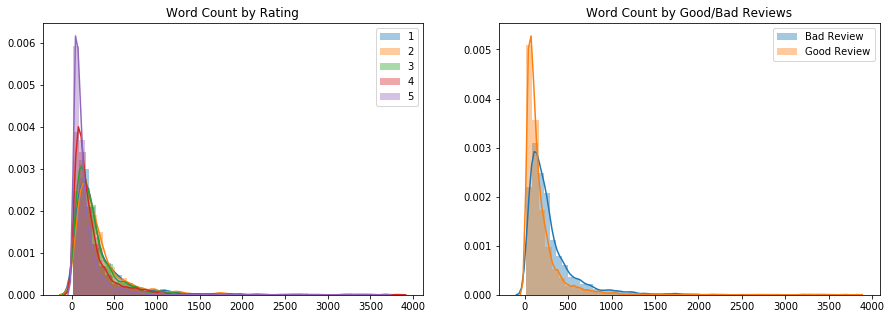

In [8]:
fig, ax = plt.subplots(figsize = (15,5),ncols = 2)

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['word_count']
titles = ['Word Count']

for a in range(len(analysis)):
    for v in range(len(values)):
        for c in analysis_dict[analysis[a]]:
            sns.distplot(reviews[reviews[analysis[a]] == c][values[v]],ax = ax[a],hist = True, kde = True)
            ax[a].legend(analysis_dict[analysis[a]])
            ax[a].set_xlabel('')
ax[0].set_title('Word Count by Rating')
ax[1].set_title('Word Count by Good/Bad Reviews')

## Sentiment Analysis - Vader

In [67]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer

In [68]:
analyzer = SentimentIntensityAnalyzer()

### Title Sentiment

In [69]:
vader_title_scores = reviews['title'].map(analyzer.polarity_scores)

In [70]:
dvec_titles = DictVectorizer()
vader_title_scores = dvec_titles.fit_transform(vader_title_scores)
for i, col in enumerate(dvec_titles.feature_names_):
    reviews['vader_title_{}'.format(col)] = vader_title_scores[:, i].toarray().ravel()

### Content Sentiment

In [71]:
vader_content_scores = reviews['content'].map(analyzer.polarity_scores)

In [72]:
dvec_content = DictVectorizer()
vader_content_scores = dvec_content.fit_transform(vader_content_scores)
for i, col in enumerate(dvec_content.feature_names_):
    reviews['vader_content_{}'.format(col)] = vader_content_scores[:, i].toarray().ravel()

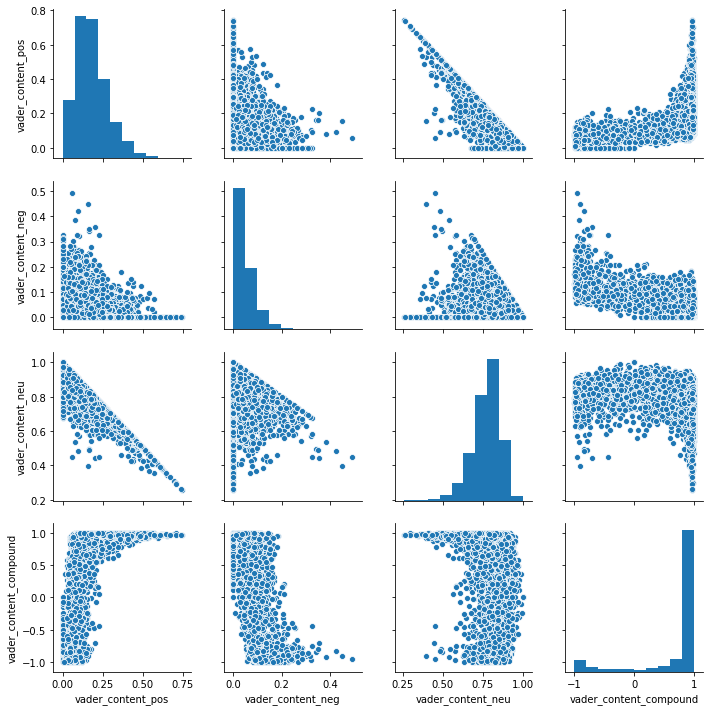

In [73]:
sns.pairplot(reviews[['vader_content_pos','vader_content_neg',
                      'vader_content_neu','vader_content_compound','stars']],
            vars = reviews[['vader_content_pos','vader_content_neg',
                            'vader_content_neu','vader_content_compound']]);#, hue = 'stars');


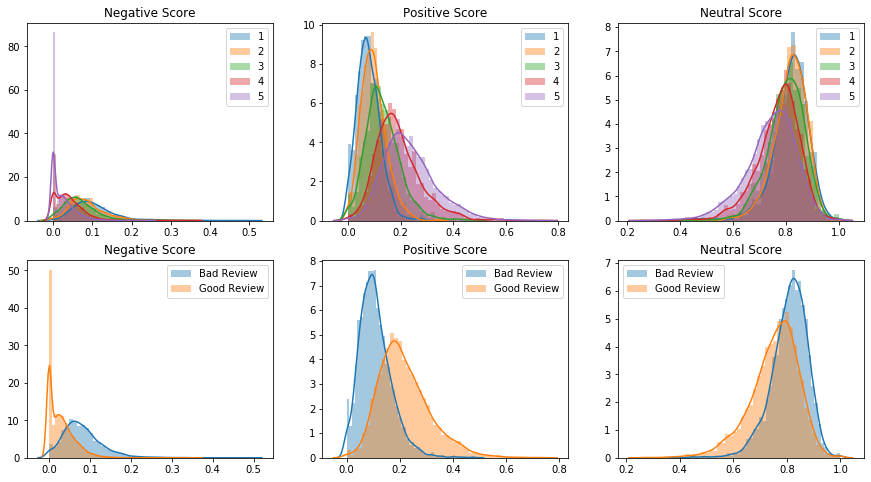

In [74]:
fig, ax = plt.subplots(figsize = (15,8),nrows = 2, ncols = 3 )

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['vader_content_neg','vader_content_pos','vader_content_neu']
titles = ['Negative Score','Positive Score','Neutral Score']


for a in range(len(analysis)):
    for v in range(len(values)):
        for c in analysis_dict[analysis[a]]:
            sns.distplot(reviews[reviews[analysis[a]] == c][values[v]],ax = ax[a][v],hist = True, kde = True)
            ax[a][v].legend(analysis_dict[analysis[a]])
            ax[a][v].set_title(titles[v])
            ax[a][v].set_xlabel('')

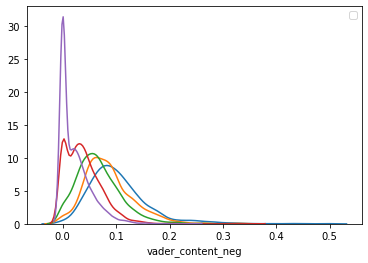

In [24]:
fig, ax = plt.subplots(figsize = (6,4))

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['vader_content_neg','vader_content_pos','vader_content_neu']
titles = ['Negative Score','Positive Score','Neutral Score']

for x in [1,2,3,4,5]:
        sns.distplot(reviews[reviews['stars'] == x]['vader_content_neg'],ax = ax,hist =False, kde = True)
        ax.legend(['1 star','2 stars','3 stars','4 stars','5 stars'])

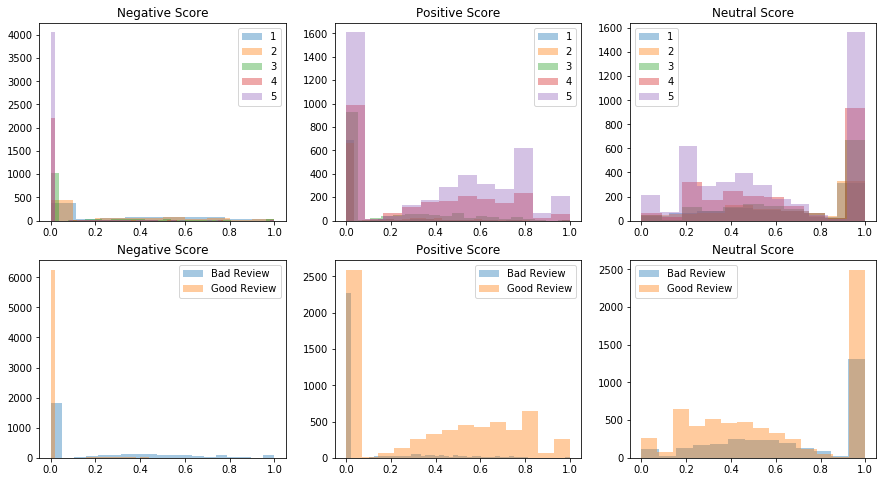

In [75]:
fig, ax = plt.subplots(figsize = (15,8),nrows = 2, ncols = 3 )

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['vader_title_neg','vader_title_pos','vader_title_neu']
titles = ['Negative Score','Positive Score','Neutral Score']


for a in range(len(analysis)):
    for v in range(len(values)):
        for c in analysis_dict[analysis[a]]:
            sns.distplot(reviews[reviews[analysis[a]] == c][values[v]],ax = ax[a][v],hist = True, kde = False)
            ax[a][v].legend(analysis_dict[analysis[a]])
            ax[a][v].set_title(titles[v])
            ax[a][v].set_xlabel('')

In [76]:
reviews.to_csv('reviews_step_2.csv')

## Word Analysis

In [1]:
# Loading latest Data
reviews = pd.read_csv('reviews_step_2.csv', index_col=0)
reviews.shape

NameError: name 'pd' is not defined

In [10]:
#Loading libraries
import textacy
from tqdm import tqdm_notebook

In [11]:
# Tokenising all words
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

def process_text(documents, pos=False):
    '''
    cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

texts, tokenised_text = process_text(reviews.content)

In [101]:
print(texts[0])

sailed MSC Meraviglia time January 2020 Western Caribbean   2nd sailing MSC Yacht Club MSC Seaside pros cons trip fair balanced   Ship stunning promenade digital screen ceiling awesome decor amazing Embarkation Pretty smooth found YC tent terminal signage port greatly improve   YC Deluxe Suite having sailed MSC expected cabin similar Seaside felt slightly bigger closet space tight plenty room 2 people anymore space Bathroom fine standard   bed comfortable decor pleasant balcony spacious comfortable Fresh Fruit sparkling wine welcomed embarkation day   Service Yacht Club level Ship Ship concept pay premium price provided inclusive private area accessible YC guests   paying price expect consistent notch service   Unfortunately case   missed opportunities inconsistency level service received YC guest assigned butler person provide service   care wants needs pleasant Butler actually scarce sailing saw time time feel providing Butler service came expect experience Seaside   said Junior Butl

In [13]:
# Separting tokens into different columns

# Empty dictionary
type_dict = {'ADJ':[],
    'ADP':[],
    'ADV':[],
    'CCONJ':[],
    'DET':[],
    'INTJ':[],
    'NOUN':[],
    'NUM':[],
    'PART':[],
    'PRON':[],
    'PROPN':[],
    'SCONJ':[],
    'SPACE':[],
    'SYM':[],
    'VERB':[],
    'X':[]}

# Organising text in each review
for rnum in range(len(tokenised_text)):
    for key in type_dict.keys():
        type_dict[key].append('')   
    for word in tokenised_text[rnum]:
        type_dict[word.pos_][rnum]+=word.lower_+' '
    type_dict[word.pos_][rnum] = type_dict[word.pos_][rnum].strip()
    
# Creating new dataframe with wordcount and a column for each word type    
word_type = pd.DataFrame(type_dict,index = reviews.index)
word_type['word_count'] = [len(x) for x in tokenised_text]
word_type_df = word_type.join(reviews.stars_grouped)

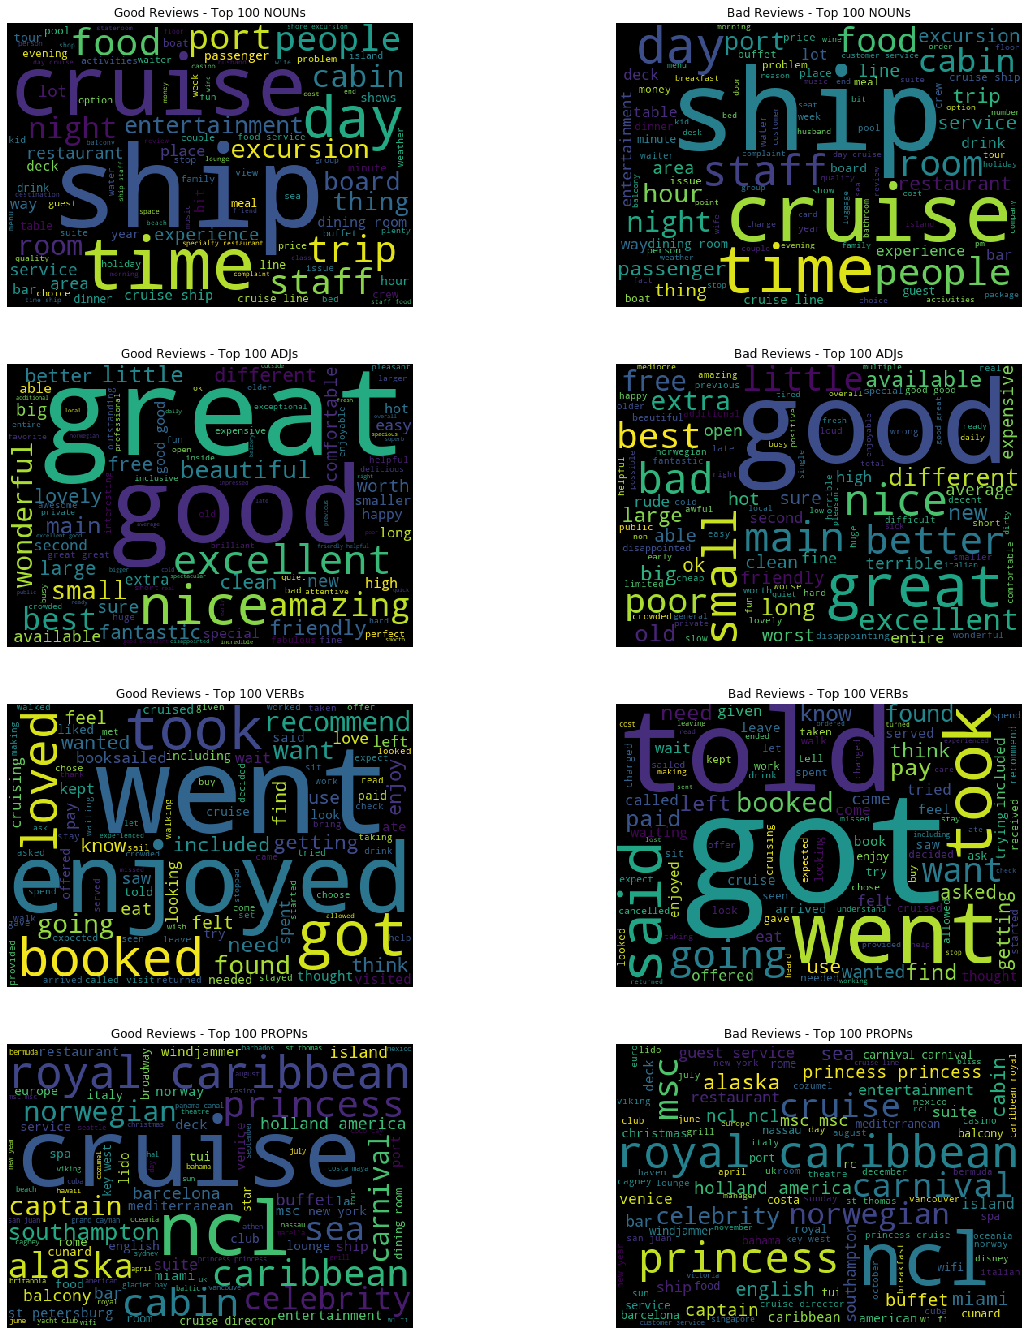

In [81]:
word_type_list = ['NOUN','ADJ','VERB','PROPN']
review_type_list = ['Good Review','Bad Review']

fig, ax = plt.subplots(ncols = len(review_type_list),nrows = len(word_type_list),
                       figsize = (20,len(word_type_list)*6))


for wtype in range(len(word_type_list)):
    for rtype in range(len(review_type_list)):
        r_text = ''
        r_text= ''.join(line for line in 
                              word_type_df[word_type_df.stars_grouped==review_type_list[rtype]]
                              [word_type_list[wtype]])

        wordcloud = WordCloud(width=500,height=350, max_words=100,relative_scaling=1,normalize_plurals=True
                                 ).generate(r_text)
        
        ax[wtype][rtype].imshow(wordcloud)
        ax[wtype][rtype].axis('off')
        ax[wtype][rtype].set_title('{}s - Top 100 {}s'.format(
            review_type_list[rtype],word_type_list[wtype]))
    

Good Reviews - Top 100 NOUNs


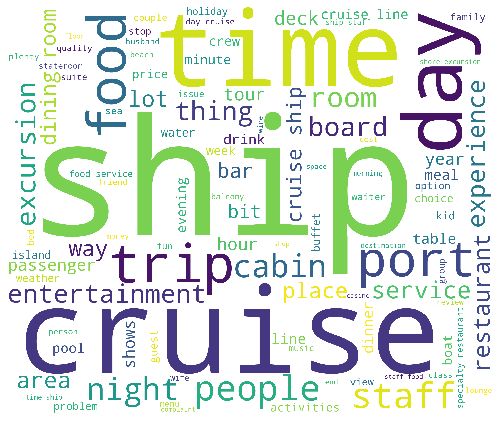

Bad Reviews - Top 100 NOUNs


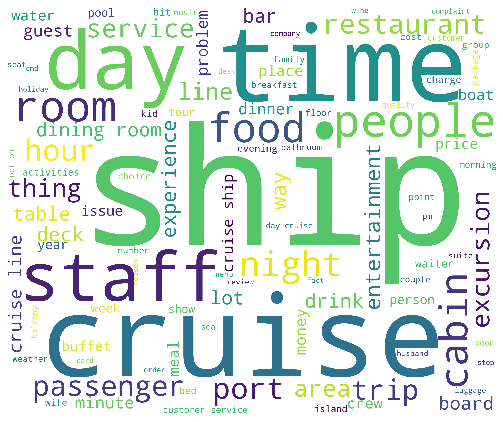

Good Reviews - Top 100 ADJs


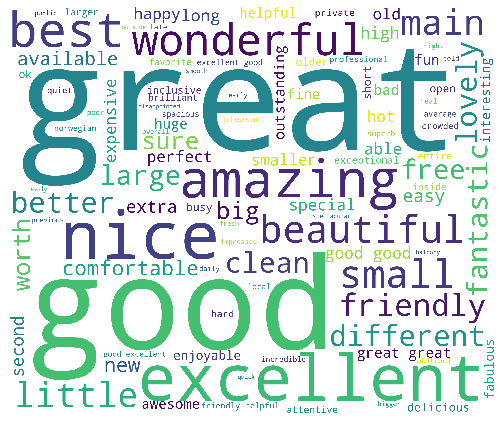

Bad Reviews - Top 100 ADJs


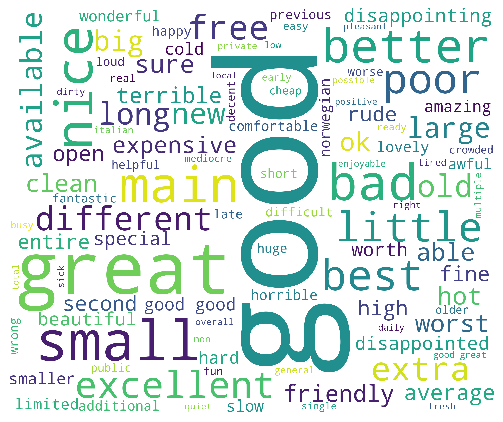

Good Reviews - Top 100 VERBs


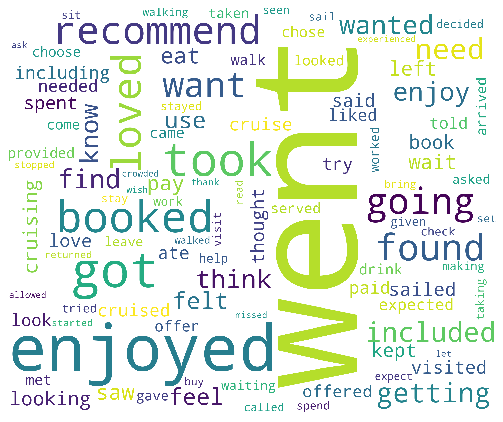

Bad Reviews - Top 100 VERBs


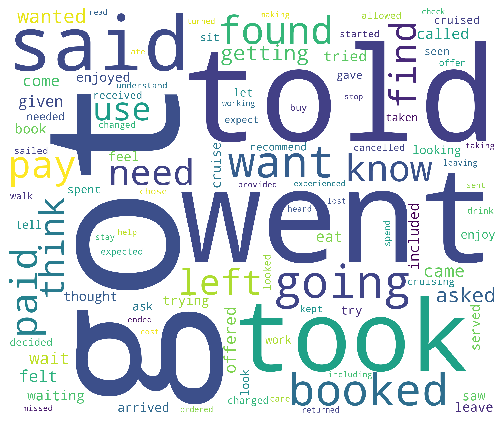

Good Reviews - Top 100 PROPNs


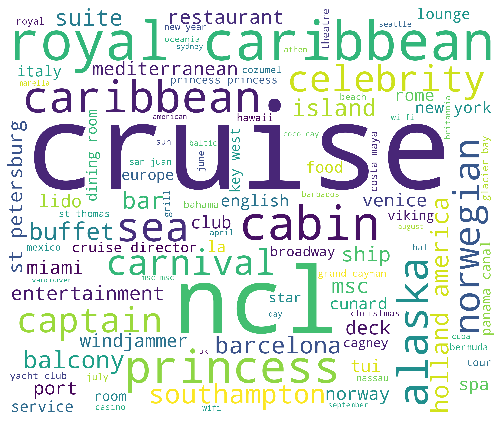

Bad Reviews - Top 100 PROPNs


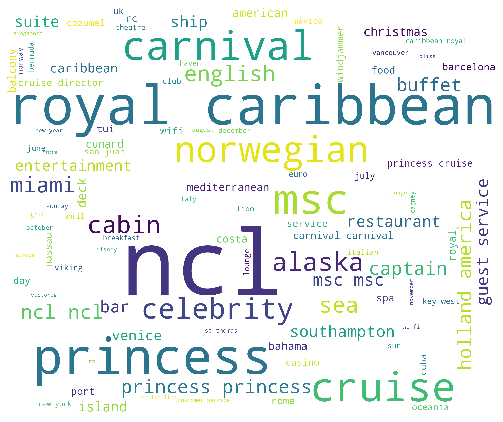

In [29]:
word_type_list = ['NOUN','ADJ','VERB','PROPN']
review_type_list = ['Good Review','Bad Review']




for wtype in range(len(word_type_list)):
    for rtype in range(len(review_type_list)):
        print('{}s - Top 100 {}s'.format(
            review_type_list[rtype],word_type_list[wtype]))
        fig, ax = plt.subplots(
                       figsize = (9,7.5))
        r_text = ''
        r_text= ''.join(line for line in 
                              word_type_df[word_type_df.stars_grouped==review_type_list[rtype]]
                              [word_type_list[wtype]])

        wordcloud = WordCloud(width=2400,height=2000, max_words=100,relative_scaling=1,
                              normalize_plurals=True,background_color = 'white'
                                 ).generate(r_text)
        
        ax.imshow(wordcloud)
        ax.axis('off')
        plt.show()

    

In [25]:
reviews.to_csv('reviews_step_5.csv')

In [14]:
save_pickle(word_type_df,'word_type.pkl')

In [15]:
word_type_df = load_pickle('word_type.pkl')

In [16]:
word_type_df

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,SCONJ,SPACE,SYM,VERB,X,word_count,stars_grouped
0,2nd fair stunning awesome amazing smooth simil...,unlike,pretty greatly slightly anymore unfortunately ...,and/or,,,time sailing pros cons trip promenade screen c...,2020 2 2 3 2 3,,,msc meraviglia january western caribbean msc y...,like despite,...,/,sailed balanced found improve having sailed ex...,,386,Good Review
1,huge decent major aft good efficient polite co...,,partly matter later best maybe,,,yes,ship nightmare shape venue deal elevators sect...,4,,,why?food mediocre al dente carrots americans e...,,,/,walking wait send requested came know hire eat...,,107,Bad Review
2,happy wonderful negative worried large beautif...,,little freshly onboard highly,,,,cruise experience reviews complaints ship faci...,"5,000",,,msc meraviglia caribbean shampoo msc meraviglia,,,,came read ate like eat baked order having incl...,i’ve,108,Good Review
3,bad excellent small little ready normal small ...,,overall early maybe maybe,,,oh sorry,cruise adventure things trip food balcony buff...,10087 2:30pm 4pm 4pm 6pm 6pm 20 15 7:30pm 5:30...,,,cabin bella supervisor security security x ray...,,,,enjoyed boarded wait called said arrive arrive...,wen't,174,Good Review
4,important worried long long wrong half quick e...,,purely little walkway away absolutely rarely e...,,,,cruise ship relaxation ports review embarkatio...,5080,,,playa del carmen mexico meraviglia caribbean b...,near like like like,,#,live enjoying live said let begin admit gettin...,,453,Good Review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9591,interesting clean clean tired unorganized,,,,,,day room coffee table refrigerator info langua...,20,,,europe miami trip un genoa,like,,,crossing ask vents went heard share asked fill...,,37,Bad Review
9592,charming nice proper efficient true profession...,,promptly specially efficiently,,,,cruise experience corner suite member crew eye...,2014 2015,,,divina divina msc,,,,enjoyed decided repeat splurged feel look list...,,60,Good Review
9593,second beautiful great friendly good best beau...,,,,,yes,time ship pizzas ship friends pm shows slices ...,10 france!!!!next,,,la guadeloupe french island french france fran...,,,,travel feel resist stop visit speak came went ...,,78,Good Review
9594,transatlantic long interesting good limited ni...,,reasonably hard,,,,cruise days time people world food choices lob...,21 7 4 2 1 5 6,,,france africa russia germany spain italy u.s. ...,,,-,enjoyed meet buy understand limited recorded,etc,71,Bad Review


## Noun categories

In [24]:
reviews = pd.read_csv('reviews_step_5.csv')

In [25]:
nouns = pd.read_csv('nouns.csv')
nouns.columns = ['word','cat','count']

In [26]:
nouns.cat.unique()

array(['Ac&Am', 'Ship', 'Cleaningless', nan, 'Food', 'Staff', 'Room',
       'Service', 'Tours', 'Price', 'Family', 'Destinations', 'Bathrooms'],
      dtype=object)

In [27]:
ship_w = list(nouns[nouns.cat == 'Ship'].word.values)
food_w = list(nouns[nouns.cat == 'Food'].word.values)
staff_w = list(nouns[nouns.cat == 'Staff'].word.values)
room_w = list(nouns[nouns.cat == 'Room'].word.values)
service_w = list(nouns[nouns.cat == 'Service'].word.values)
Ac_Am_w = list(nouns[nouns.cat == 'Ac&Am'].word.values)
internet_w = list(nouns[nouns.cat == 'Internet'].word.values)
destinations_w = list(nouns[nouns.cat == 'Destinations'].word.values)
bathrooms_w = list(nouns[nouns.cat == 'Bathrooms'].word.values)

## Labeler

In [28]:
import re

In [37]:
test = reviews.content[10
                    ]
test

'Yes, the ship is enormous (almost 5,000 passengers), beautiful and the cabins are great (except for the very small bathroom).  The food is a 7.5-8.0 rating.  Som4e good meals but others disappointing.  Best food for dinner is on deck 15 at the Market Place but the dining room is OK.  Breakfast for sure is in the dining room.  Too many people to my liking and the background music around the pool is too loud and incessant.  Cabin steward and staff are excellent but most suffer from having a good understanding of English.  Shows were very good and Cirque de Soleil was imaginative and colorful.  Ports of call OK but the biggest disappointment is you must expect to PAY for MANY things...even orders for the cabin cost $$.'

In [38]:
ship = ['ship']

def labeler(review):
    sentences = re.split(r'\.',review)
    sentences = [rev.lower().strip() for rev in sentences if rev != '']
    labeled = []
    for sentence in range(len(sentences)):
        temp = re.sub('\s\s+',' ',re.sub('([^\w\s])',' ',sentences[sentence])).split(' ')
        labels = set()
        for word in ship_w:
            if word in temp:
                labels.add('ship')
                print('ship - '+ word)
                temp.remove(word)       
        for word in food_w:
            if word in temp:
                labels.add('food')
                print('food - '+ word)
                temp.remove(word)
        for word in staff_w:
            if word in temp:
                labels.add('staff')
                print('staff - '+word)
                temp.remove(word)
        for word in room_w:
            if word in temp:
                labels.add('room')
                print('room - '+word)
                temp.remove(word)
        for word in service_w:
            if word in temp:
                labels.add('service')
                print('service - '+word)
                temp.remove(word)
        for word in Ac_Am_w:
            if word in temp:
                labels.add('Ac&Am')
                print('ac&am - '+word)
                temp.remove(word)
        for word in destinations_w:
            if word in temp:
                labels.add('destinations')
                print('dest - '+word)
                temp.remove(word)
        for word in bathrooms_w:
            if word in temp:
                labels.add('bathrooms')
                print('bathrooms - '+word)
                temp.remove(word)
        if len(labels) == 0:
            pass
        labeled.append((list(labels),sentences[sentence]))

   
            
                
    return labeled
    
    
labeler(test)

room - cabins
room - bathroom
food - food
food - meals
food - food
food - dining
food - dinner
room - room
food - dining
food - breakfast
room - room
ac&am - pool
ac&am - music
staff - staff
staff - steward
room - cabin
ac&am - shows
room - cabin


[(['room'],
  'yes, the ship is enormous (almost 5,000 passengers), beautiful and the cabins are great (except for the very small bathroom)'),
 (['food'], 'the food is a 7'),
 ([], '5-8'),
 ([], '0 rating'),
 (['food'], 'som4e good meals but others disappointing'),
 (['room', 'food'],
  'best food for dinner is on deck 15 at the market place but the dining room is ok'),
 (['room', 'food'], 'breakfast for sure is in the dining room'),
 (['Ac&Am'],
  'too many people to my liking and the background music around the pool is too loud and incessant'),
 (['staff', 'room'],
  'cabin steward and staff are excellent but most suffer from having a good understanding of english'),
 (['Ac&Am'],
  'shows were very good and cirque de soleil was imaginative and colorful'),
 ([],
  'ports of call ok but the biggest disappointment is you must expect to pay for many things'),
 (['room'], 'even orders for the cabin cost $$')]

In [ ]:
ship = 'number of people','capacity'
service = 'clean'
amenities = 'hot tubs','mini-golf','water slides'
activities = 'nightlife'


print(food_w)

In [ ]:
#create cleaningless
Group amenities and activities
find oput what's happening with food



In [ ]:
reviews[reviews.trip_type.isna()][]

In [150]:
if 'temp' in ['temporary','hernan']:
    print(True)

# Models

In [ ]:
reviews.columns

In [ ]:
from patsy import dmatrices

In [ ]:
formula = 'stars ~ vader_content_neg + vader_content_neu + vader_content_pos + word_count'
y, X = dmatrices(formula,reviews)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.25, random_state = 31,stratify = y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
modeldt = DecisionTreeClassifier()
modeldt.fit(Xtrain,)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
log_basic_dict = {
    'penalty':['l1','l2'],
    'solver': ['liblinear'],
    'Cs':[10]
} 
log_basic = GridSearchCV(LogisticRegressionCV(),log_basic_dict,)

#GridSearchCV(LogisticRegression(),log_basic_dict)
log_basic.fit(Xtrain,ytrain)

In [ ]:
log_basic.score(Xtrain,ytrain)

In [ ]:
log_basic.score(Xtest,ytest)

In [ ]:
log_basic.best_score_

In [ ]:
ytrain.value_counts(normalize = True)

In [ ]:
reviews.sort_values(by = 'user_contributions', ascending = False)